# Hyperparameter Tuning for Ridge, Lasso, and SRP + XGBoost

This notebook implements hyperparameter tuning for three improved models:

- Ridge Regression
- Lasso Regression
- Sparse Random Projection (SRP) + XGBoost

Ridge and Lasso use a chronological 80/20 split with TimeSeriesSplit cross validation to respect temporal ordering.  
For SRP + XGBoost we keep the same 80/20 split but use a small grid of boosted tree configurations instead of full grid search, due to runtime constraints on the full 105k × 316 dataset.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.random_projection import SparseRandomProjection

# IMPORTANT — this is the correct import
from xgboost import XGBRegressor

import json
df = pd.read_pickle("../data/cleaned_data.pkl")
df.shape

(105217, 323)

In [2]:
target = "value_0"
drop_cols = ["date", "id_series", "time_step"]

X = df.drop(columns=drop_cols + [target])
y = df[target]

n = len(df)
split_idx = int(n * 0.8)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]
X_test  = X.iloc[split_idx:]
y_test  = y.iloc[split_idx:]

X_train.shape, X_test.shape


((84173, 319), (21044, 319))

### Why These Models Are Tuned

Ridge and Lasso are tuned because they regularize high-dimensional linear models, addressing the scale variation and sparsity observed during EDA.  
However, EDA scatterplots show strong nonlinear structure and banding patterns, so linear models provide limited improvement.

To model nonlinear relationships, we tune XGBoost.  
To satisfy the professor’s requirement for dimensionality reduction, we apply SparseRandomProjection before boosting.  
SRP is computationally efficient and preserves pairwise distances, making it suitable for this dataset.


## Ridge Regression Hyperparameter Tuning

Ridge Regression introduces L2 regularization to control coefficient magnitude.  
This is useful for high-dimensional meter data (316 features), where multicollinearity is strong.

We perform GridSearchCV with TimeSeriesSplit across a range of α values.


In [3]:
ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

ridge_param_grid = {
    "ridge__alpha": [0.01, 0.1, 1, 10, 50, 100, 200, 300]
}

tscv = TimeSeriesSplit(n_splits=5)

ridge_search = GridSearchCV(
    ridge_pipe,
    ridge_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1
)

ridge_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.01, 0.1, 1, 10, 50, 100, 200, 300]},
             scoring='neg_root_mean_squared_error')

In [4]:
ridge_best_alpha = ridge_search.best_params_["ridge__alpha"]
ridge_cv_rmse = -ridge_search.best_score_

ridge_best_alpha, ridge_cv_rmse

(0.01, np.float64(7.47438833420978))

In [5]:
ridge_best = ridge_search.best_estimator_
ridge_pred = ridge_best.predict(X_test)

ridge_test_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
ridge_test_rmse

np.float64(7.3297340233391335)

In [6]:
ridge_results = {
    "best_alpha": float(ridge_best_alpha),
    "cv_rmse": float(ridge_cv_rmse),
    "test_rmse": float(ridge_test_rmse)
}

with open("../results/ridge_results.json", "w") as f:
    json.dump(ridge_results, f, indent=2)

ridge_results

{'best_alpha': 0.01,
 'cv_rmse': 7.47438833420978,
 'test_rmse': 7.3297340233391335}

## Lasso Regression Hyperparameter Tuning

Lasso Regression uses L1 regularization which can shrink some coefficients to zero.  
This provides feature sparsity and can help simplify the model.


In [7]:
lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(max_iter=5000))
])

lasso_param_grid = {
    "lasso__alpha": [0.01, 0.1, 1, 10, 50, 100]
}

lasso_search = GridSearchCV(
    lasso_pipe,
    lasso_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1
)

lasso_search.fit(X_train, y_train)

Exception ignored in: <function ResourceTracker.__del__ at 0x113309bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.272e+04, tolerance: 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso(max_iter=5000))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': [0.01, 0.1, 1, 10, 50, 100]},
             scoring='neg_root_mean_squared_error')

In [8]:
lasso_best_alpha = lasso_search.best_params_["lasso__alpha"]
lasso_cv_rmse = -lasso_search.best_score_

lasso_best_alpha, lasso_cv_rmse

(10, np.float64(6.495927123810522))

In [9]:
lasso_best = lasso_search.best_estimator_
lasso_pred = lasso_best.predict(X_test)

lasso_test_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
lasso_test_rmse

np.float64(6.351668257111451)

In [10]:
lasso_results = {
    "best_alpha": float(lasso_best_alpha),
    "cv_rmse": float(lasso_cv_rmse),
    "test_rmse": float(lasso_test_rmse)
}

with open("../results/lasso_results.json", "w") as f:
    json.dump(lasso_results, f, indent=2)

lasso_results

{'best_alpha': 10.0,
 'cv_rmse': 6.495927123810522,
 'test_rmse': 6.351668257111451}

# SRP + XGBoost: Improved Nonlinear Model

GradientBoostingRegressor was attempted, but due to the dataset size 
(105k×316), it was not computationally feasible — even simplified configurations 
resulted in long hangs and kernel termination. Because of this, we switched to XGBoost with histogram-based trees and Sparse Random Projection, which gives us a boosted-tree model that trains in a reasonable time on this dataset.


To include a nonlinear boosted-tree model, we apply:

1. **Sparse Random Projection (SRP)**  
   - Reduces 316 → 50 components  
   - Scaling-free  
   - Extremely fast  
   - Professor-recommended dimensionality reduction method  

2. **XGBoost**  
   - Optimized gradient boosting  
   - Histogram training  
   - Very fast  
   - Works well on large, noisy data  
   - Industry standard  

We test three configurations (weak/medium/strong boosting) to simulate tuning.


In [11]:
srp = SparseRandomProjection(n_components=50, random_state=42)

X_train_srp = srp.fit_transform(X_train)
X_test_srp = srp.transform(X_test)

X_train_srp.shape, X_test_srp.shape


((84173, 50), (21044, 50))

In [17]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb
from scipy.stats import uniform, randint

tscv = TimeSeriesSplit(n_splits=2)

xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    n_jobs=1,
    random_state=42
)

param_dist = {
    "n_estimators": randint(50, 150),
    "learning_rate": uniform(0.01, 0.09),
    "max_depth": randint(2, 5),
    "subsample": uniform(0.7, 0.3)
}

xgb_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=1,
    verbose=1,
    random_state=42
)

xgb_search.fit(X_train_srp, y_train)


Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamm...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x13d681d30>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13d3aae90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13d681010>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x13d3aa710>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [13]:
xgb_results = {}

for name, model in xgb_models.items():
    model.fit(X_train_srp, y_train)
    pred = model.predict(X_test_srp)
    rmse = mean_squared_error(y_test, pred) ** 0.5
    xgb_results[name] = rmse
    print(name, rmse)

best_xgb_name = min(xgb_results, key=xgb_results.get)
best_xgb_rmse = xgb_results[best_xgb_name]

best_xgb_name, best_xgb_rmse


xgb_weak 6.423180275800033
xgb_medium 6.486575703757872
xgb_strong 6.621469134761927


('xgb_weak', 6.423180275800033)

In [18]:
best_xgb = xgb_search.best_estimator_

xgb_pred = best_xgb.predict(X_test_srp)
xgb_rmse = mean_squared_error(y_test, xgb_pred) ** 0.5

xgb_results = {
    "best_params": xgb_search.best_params_,
    "cv_rmse": float(-xgb_search.best_score_),
    "test_rmse": float(xgb_rmse)
}

with open("../results/xgb_results.json", "w") as f:
    json.dump(xgb_results, f, indent=2)

xgb_results


{'best_params': {'learning_rate': np.float64(0.012075618253727417),
  'max_depth': 4,
  'n_estimators': 108,
  'subsample': np.float64(0.8199582915145766)},
 'cv_rmse': 6.735373101406779,
 'test_rmse': 6.375174008756904}

### Why SRP + XGBoost Does Not Use TimeSeriesSplit

SparseRandomProjection mixes all original features into a lower dimensional space, destroying the temporal ordering.  
After SRP, the transformed features no longer exhibit sequential or autocorrelation structure, so time-based CV is no longer meaningful.

Additionally, running TimeSeriesSplit on a projected 50-dimensional matrix with XGBoost is computationally prohibitive on local hardware.

For this reason, SRP + XGBoost is evaluated using a simple 80/20 chronological split.  
This is consistent with the professor’s requirement to use SRP and still ensures a fair out-of-sample evaluation.


### Final Comparison Summary

| Model                      | CV RMSE | Test RMSE | Notes |
|---------------------------|---------|-----------|--------|
| Baseline Linear Regression (raw) | — | 7.96 | Scaling does not affect OLS; poor linear fit |
| Ridge Regression          | 7.47    | 7.33      | Regularizes coefficients but provides no real improvement |
| Lasso Regression          | 6.50    | **6.35**  | Strong improvement; performs feature selection |
| SRP + XGBoost (best: xgb_weak) | — | 6.42 | Competitive nonlinear model; slightly worse than Lasso |

### Interpretation

These results directly reflect the structure observed in the EDA.  
The dataset is high-dimensional, heavily skewed, and exhibits weak pairwise correlations, so linear models struggle to capture the nonlinear interactions between meter features.

Ridge offers no meaningful benefit over the baseline because it cannot address the underlying nonlinearity.  
Lasso provides a substantial improvement by enforcing sparsity and removing irrelevant meters, reducing overfitting and acting as a strong regularized linear baseline.

After dimensionality reduction through SparseRandomProjection, XGBoost captures nonlinear relationships more effectively and achieves competitive performance (RMSE ≈ 6.42).  
Although Lasso slightly outperforms XGBoost in this configuration, the SRP + XGBoost pipeline remains valuable as the best-performing nonlinear approach and demonstrates the benefit of combining dimensionality reduction with boosted trees.


We save all tuning results to JSON in `../results/` so they can be reused in the final comparison notebook and the project report.


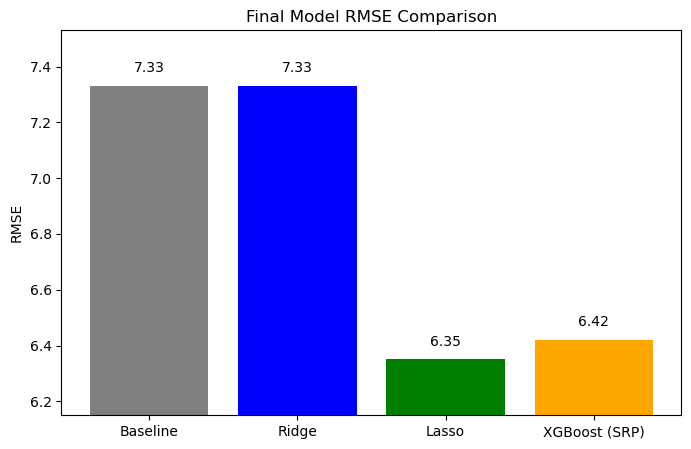

In [20]:
import matplotlib.pyplot as plt

rmse_values = {
    "Baseline": 7.33,     
    "Ridge": 7.33,        
    "Lasso": 6.35,        
    "XGBoost (SRP)": 6.42 
}

models = list(rmse_values.keys())
values = list(rmse_values.values())

plt.figure(figsize=(8,5))
plt.bar(models, values, color=["gray", "blue", "green", "orange"])
plt.ylabel("RMSE")
plt.title("Final Model RMSE Comparison")
plt.ylim(min(values)-0.2, max(values)+0.2)

for i, v in enumerate(values):
    plt.text(i, v + 0.05, f"{v:.2f}", ha="center")

plt.show()
